In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('Cuk.csv')
df = df.set_index('Time')

In [3]:
iL1 = df['iL1']
vC1 = df['vC1']
iL2 = df['iL2']
vC2 = df['vC2']

In [4]:
import matplotlib.pyplot as plt
# import mpld3
# mpld3.enable_notebook()

plt.figure(figsize=(15, 5))
plt.subplot(211)
plt.plot(iL1, label='$i_{L1}$')
plt.plot(iL2, label='$i_{L2}$')
plt.legend()
plt.grid()
plt.subplot(212)
plt.plot(vC1, label='$V_{C1}$')
plt.plot(vC2, label='$V_{C2}$')
plt.legend()
plt.grid()
plt.show()

<Figure size 1500x500 with 2 Axes>

In [5]:
import numpy as np 
import numpy.linalg as lin

In [6]:
t_step = 1e-6
t_final = .05

L1 = L2 = 500e-6
Cap1 = Cap2 = 100e-6
R = 5
Vin = 48
D = 0.4
d_f = .05
v_f = 0

In [7]:
K = np.array([[L1, 0,    0,    0], 
              [0, L2,    0,    0],
              [0,  0, Cap1,    0],
              [0,  0,    0, Cap2]])

1ª Etapa do conversor

In [8]:
A1 = np.array([[0,  0, 0,      0],
               [0,  0, 1,      1],
               [0, -1, 0,      0],
               [0,  -1,  0, -1/R]])
B1 = np.array([1, 0, 0, 0])
C1 = np.identity(4)
E1 = np.zeros(4)

2ª Etapa do conversor

In [9]:
A2 = np.array([[0, 0, -1,   0],
               [0, 0, 0,    1],
               [1, 0, 0,    0],
               [0, -1, 0, -1/R]])
B2 = np.array([1, 0, 0, 0])
C2 = np.identity(4)
E2 = np.zeros(4)

Matrizes médias

In [10]:
A = D*A1 + (1-D)*A2;
B = D*B1 + (1-D)*B2;
C = D*C1 + (1-D)*C2;
E = D*E1 + (1-D)*E2;

Valores em regime permanente

In [11]:
U = Vin
X = np.dot(np.dot(-lin.inv(A), B), U)
Y = np.dot((np.dot(np.dot(-C, lin.inv(A)), B)+E), U)

Matrizes padrão para representação do modelo CA em espaço de estados

In [12]:
Ap = np.dot(lin.inv(K),A)
print(Ap)

[[     0.      0.  -1200.      0.]
 [     0.      0.    800.   2000.]
 [  6000.  -4000.      0.      0.]
 [     0. -10000.      0.  -2000.]]


In [13]:
Bp = np.array([np.dot(lin.inv(K), B), 
               np.dot(lin.inv(K), (np.dot((A1-A2),X) + np.dot((B1-B2), U)))]).transpose()
print(Bp)

[[   2000.          160000.        ]
 [      0.          160000.        ]
 [      0.         -106666.66666667]
 [      0.               0.        ]]


In [14]:
Cp = C
print(Cp)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [15]:
Ep = np.array([E, np.dot((C1-C2),X) + np.dot((E1-E2),U)]).transpose()
print(Ep)

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [16]:
import scipy.signal as sig

In [17]:
# Aq, Bq, Cq, Eq = -4., 2., 1., 0.

In [18]:
import scipy
ss_buckboost = sig.StateSpace(Ap, Bp, Cp, Ep)
# ss_buckboost = sig.StateSpace(Aq, Bq, Cq, Eq); ss_buckboost
print(Ap.shape, Bp.shape, Cp.shape, Ep.shape)

(4, 4) (4, 2) (4, 4) (4, 2)


In [19]:
def step(t, t_step, y_inital, y_final, verbatim=False):
    ret = np.ones(t.size)
    
    yt_initial = t < t_step
    ret[yt_initial] = y_inital
    
    yt_final = t >= t_step
    ret[yt_final] = y_final
    
    import matplotlib.pyplot as plt
    
    if verbatim:
        plt.plot(t, ret)
        plt.show()

    return ret

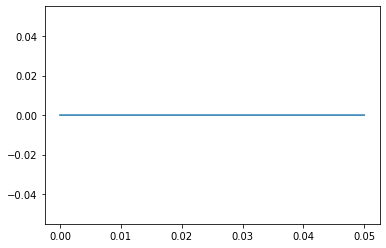

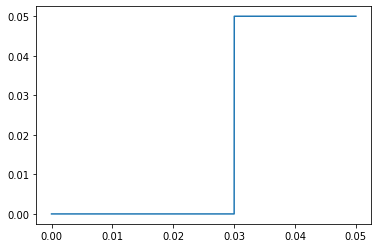

In [20]:
t_in = np.arange(0, t_final, t_step)

u = step(t_in, .03, 0, v_f, verbatim=True)
d = step(t_in, .03, 0, d_f, verbatim=True)

up = np.array([u, d]).transpose()

y1 is diffrent to y2: 200004 de 200004


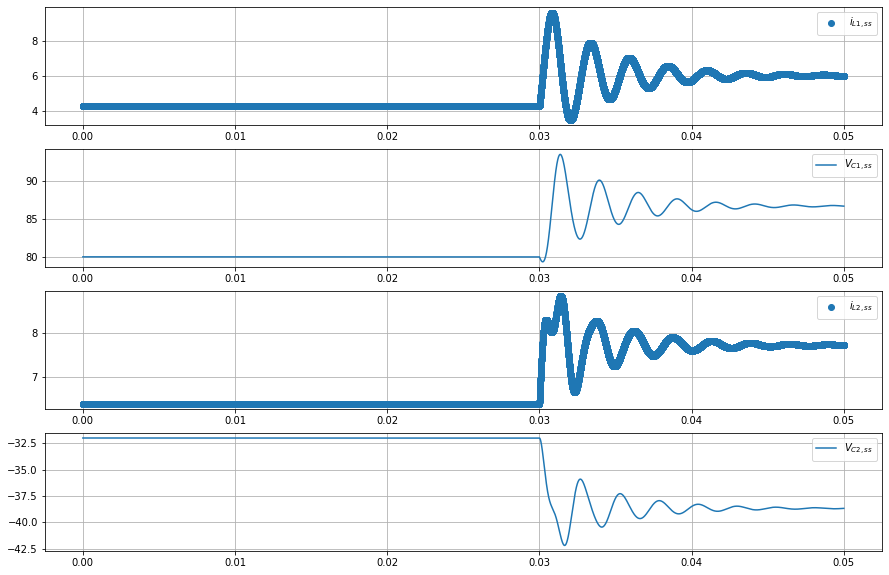

In [21]:
t, y1, y2 = sig.lsim(ss_buckboost, up, T=t_in)

iL1_ss = y1[:,0] + Y[0]
iL2_ss = y1[:,1] + Y[1]

vC1_ss = y1[:,2] + Y[2]
vC2_ss = y1[:,3] + Y[3]


if np.sum(y1 == y2) != 0:
    print('y1 is diffrent to y2: %d de %d' % (np.sum(y1 == y2), y1.size))
    
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.subplot(411)
plt.plot(t, iL1_ss, 'o', label='$i_{L1, ss}$')
plt.legend()
plt.grid()
plt.subplot(412)
plt.plot(t, vC1_ss, label='$V_{C1, ss}$')
plt.legend()
# plt.tight_layout()
plt.grid()
plt.subplot(413)
plt.plot(t, iL2_ss, 'o', label='$i_{L2, ss}$')
plt.legend()
plt.grid()
plt.subplot(414)
plt.plot(t, vC2_ss, label='$V_{C2, ss}$')
plt.legend()
# plt.tight_layout()
plt.grid()

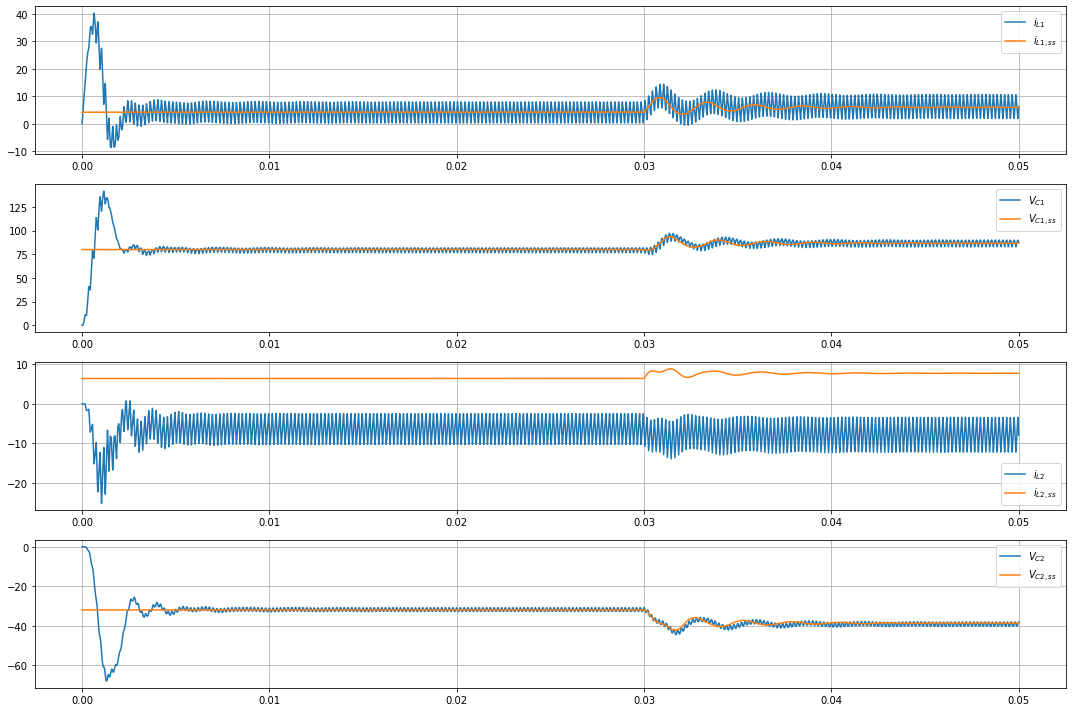

In [22]:
plt.figure(figsize=(15, 10))
plt.subplot(411)
plt.plot(df.index, iL1, label='$i_{L1}$')
plt.plot(t, iL1_ss, label='$i_{L1, ss}$')
# plt.ylim(-5, 25)
plt.legend()
plt.grid()
plt.subplot(412)
plt.plot(df.index, vC1, label='$V_{C1}$')
plt.plot(t, vC1_ss, label='$V_{C1, ss}$')
# plt.ylim(-45, -5)
plt.legend()
plt.subplot(413)
plt.plot(df.index, iL2, label='$i_{L2}$')
plt.plot(t, iL2_ss, label='$i_{L2, ss}$')
# plt.ylim(-5, 25)
plt.legend()
plt.grid()
plt.subplot(414)
plt.plot(df.index, vC2, label='$V_{C2}$')
plt.plot(t, vC2_ss, label='$V_{C2, ss}$')
# plt.ylim(-45, -5)

plt.legend()
plt.tight_layout()
plt.grid()